In [22]:
import re
import random
from typing import List, Optional, Tuple, Union

import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions

In [23]:
# reproductibilidad

random.seed(42)

np.random.seed(42)

torch.manual_seed(42)

# Transformers for language generation

## The goal

## Language generation: write (sound like) as Shakespeare

Our goal is to write as Shakespeare, but off course this problem is very difficult so by now we are content to sound like Shakespeare 😅

## The dataset

To sound as Shakespeare we have a learning source: Measure for Measure, a play from William Shakespeare written in 1603, where the author
handle topics as morality, power and forgiveness.

## The model

On this project you will find two models for text generation:

- A transformers model built from zero
- A fine-tuned version of GPT2 ([OpenAI paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf))

## Tech stack

In order to solve the problem the next libraries are used:

1. Pytorch
2. Transformers, from hugging face
3. GTP causal model implementations and GTP tokenizers

## Project structure

This project involves an e2e deep learning task, from dataset processing, to model generation, so we dived the whole problem in various subfolders:

- **architecture**: Common machine learning artifacts and modules, like `SelfAttention` and other layer implementations
- **data**: All logic for load the input datasets and convert them into vectorized pairs `(x, y)`, using a tokenizer (seen later)
- **models**: The final architectures that learns how to generate text that sounds like Shakespeare using all **architecture** artifacts.
- **train**: The connector between datasets and models, there we handle all logic about model training and exports.

## The first thing: the dataset

As you may know, one of the most important parts of machine learning solutions is off course the data.

In order to sound like Shakespeare we have two main sources of information, extracted from the whole *Measure by Measure* play, its document has 40k lines.

- **data/static/train.txt**: The first 32k lines of *Measure by Measure* play
- **data/static/test.txt**: The last 8k lines of *Measure by Measure* play

As you can see at `data.datasets.tokenized` we implement all the logic to perform the next pipeline:

![Dataset pipeline](https://media.githubusercontent.com/media/lgemc/pytorch_training_course/refs/heads/master/static/data_pipeline.png)

## Batch size per words and tokens

As you may know, the tokenizer receives a max amount of words to be tokenized, its context length it is not unlimited,
so we should tokenize by chunks in order to get it working properly.

So we split the whole file into chunks of size 140 words.

We also use the same amount of tokens per pair x, y (x a batch of 140 tokens, y is x shifted to left with also 140 tokens)

## Synthethic dataset samples expantion

The whole dataset has got 202651 words, so we only can have 2026 samples for our model, in order to
increase this and to **has a more diverse dataset in a synthetic way** we generate some random indexes
to extract extra sequences from the dataset, additional to the original 2026 samples.

## Data tokenization

In order to convert the data into vectors we use the original `GTP2Tokenizer` which has a vocabulary of 50.257 tokens.

In [24]:
class TokenizedDataset(Dataset):
    def __init__(
            self,
            file_name: str,
            tokenizer=None,
            batch_size_words=100,
            max_token_length=600,
            amount_of_samples=None,
    ):
        self.batch_size_words = batch_size_words
        self.max_token_length = max_token_length
        if tokenizer is not None:
            self.tokenizer = tokenizer
        else:
            self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

        self.tokenizer.pad_token = self.tokenizer.eos_token

        with open(file_name) as file:
            self._raw_content = file.read()

        # Split text into words while preserving whitespace
        self.words_with_spaces = re.findall(r'\S+|\s+', self._raw_content)
        # Create word batches and tokenize them
        self.tokenized_batches = []
        self.batch_start_indices = []

        # Create a single tokenized tensor for the entire text
        self.tokenized = self.tokenizer.encode(self._raw_content)
        self.tokenized = torch.tensor(self.tokenized).long()

        self._vocab_size = len(self.tokenizer)

        self._indexes = []
        for i in range(0, len(self.tokenized) - self.max_token_length, self.max_token_length):
            self._indexes.append(i)

        # If there's a remainder, include it as the last sequence
        if len(self.tokenized) - self.max_token_length > 0:
            last_valid_start = len(self.tokenized) - self.max_token_length
            if last_valid_start not in self._indexes:
                self._indexes.append(last_valid_start)

        if amount_of_samples is not None:
            if amount_of_samples < len(self._indexes):
                pass
            else:
                for i in range(len(self._indexes), amount_of_samples):
                    self._indexes.append(random.randint(0, len(self.tokenized) - self.max_token_length))

        # Shuffle the indexes
        random.shuffle(self._indexes)

        self._num_sequences = len(self._indexes)

    def __len__(self):
        return self._num_sequences

    def __getitem__(self, idx):
        start_idx = self._indexes[idx]
        end_idx = min(start_idx + self.max_token_length, len(self.tokenized))

        # Get input sequence
        x = self.tokenized[start_idx:end_idx]

        # If the sequence is shorter than max_token_length, pad it
        if len(x) < self.max_token_length:
            padding = torch.full((self.max_token_length - len(x),), self.tokenizer.pad_token_id)
            x = torch.cat([x, padding])

        # Get target sequence (shifted by 1)
        y_start = start_idx + 1
        y_end = min(y_start + self.max_token_length, len(self.tokenized))
        y = self.tokenized[y_start:y_end]

        # Pad y if necessary
        if len(y) < self.max_token_length:
            print(f"padded tokens")
            padding = torch.full((self.max_token_length - len(y),), self.tokenizer.pad_token_id)
            y = torch.cat([y, padding])

        return x, y

    @property
    def vocab_size(self):
        return self._vocab_size

In [25]:
batch_size_words = 140
max_token_length = 140
amount_of_train_samples = 3000
amount_of_test_samples = 600

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

vocab_size = tokenizer.vocab_size

train_dataset  = TokenizedDataset(
    "./data/train.txt",
    tokenizer = tokenizer,
    batch_size_words = batch_size_words,
    max_token_length = max_token_length,
    amount_of_samples = amount_of_train_samples,
)

test_dataset = TokenizedDataset(
    "./data/test.txt",
    tokenizer = tokenizer,
    batch_size_words = batch_size_words,
    max_token_length = max_token_length,
    amount_of_samples = amount_of_test_samples,
)

print(f"Tran and test datasets loaded. Train len: {len(train_dataset)}, Test len {len(test_dataset)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (272058 > 1024). Running this sequence through the model will result in indexing errors


Tran and test datasets loaded. Train len: 3000, Test len 600


## First use case: Lets train the model from zero

Text generation, so how?

We have a lot of ways to train a model for text generation, like `lstms`, `rnns`, `transformers`, and this time we are going to use `transformers`

Why transformers you may think, lets talk about some context:

### LSTMS and RNNS, strengths and weaknesses

As mentioned at [A Clockwork RNN](https://arxiv.org/pdf/1402.3511), Jan Koutnin et Al, RNNS have shown high accuracy on text based tasks, as mentioned in the paper on classification tasks and sequence generation tasks.

But this kind of networks has an important weakness: the required amount of time and computation power required for train this kind of networks.

Why? because the architecture is based on sequential gradient calculation to be transferred from layer to layer, so one gradient at time step ti can not
be calculated without the gradient at ti-i, so when we have high amounts of data, like wikipedia's whole dataset, resources needed exceeds the amount
of computation power available.

## Transformers: strengths and weaknesses

As shown in the paper [Attention Is All You Need](https://arxiv.org/pdf/1706.03762) from Ashish Vaswani et al, transformer based models
for text tasks like text translation or generation can reach an accuracy near the state of the art at the time it was released (the accuracy is almost the same
or a little worse, +-0.2) but the training cost is one or two orders of magnitude less than those based on RNNS or convolutional neural network ones, like [Deep Recurrent Models with Fast-Forward Connections for Neural Machine
Translation](https://arxiv.org/pdf/1606.04199).

So off course transformers are an important topic, with strengths in accuracy but more importantly it reduces times and costs to train neural network models.

## Our first model to sound as Shakespeare: lets build from scratch

Our first model is a hand-made architecture based on transformers architecture proposed at **Attention is all you need** paper

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [27]:
class FeedForward(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim) -> None:
        super().__init__()
        self.dense1 = nn.Linear(in_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x): # x: [batch_size, block_size, head_dim]
        dense1 = F.relu(self.dense1(x)) # [batch_size, block_size, head_dim*4]
        output = self.dense2(dense1) # [batch_size, block_size, head_dim]
        return output

In [28]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, head_dim, block_size):
        # embed_dim son las dimensiones del embedding de los tokens originalmente
        # head_dim son las dimensiones del vector resultante del mecanismo de atención
        # block_size son el número de tokens que hacen parte del contexto
        super().__init__()
        self.head_dim = head_dim

        self.Wq = nn.Linear(embed_dim, head_dim, bias=False)
        self.Wk = nn.Linear(embed_dim, head_dim, bias=False)
        self.Wv = nn.Linear(embed_dim, head_dim, bias=False)

        self.register_buffer('mask', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        N, T, D = x.shape
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        att_weights = Q @ K.transpose(-1, -2)
        att_weights = att_weights * self.head_dim ** -0.5
        masked_att = att_weights.masked_fill(self.mask[:T, :T] == 0, -torch.inf)
        att_weights = torch.nn.functional.softmax(masked_att, dim=2)
        self.att_weights = att_weights
        weighted_output = att_weights @ V

        return weighted_output

In [29]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads_num, embed_dim, head_dim, block_size) -> None:
        super().__init__()
        self.heads = nn.ModuleList([SelfAttention(embed_dim, head_dim//heads_num, block_size) for _ in range(heads_num)])
        self.dense = nn.Linear(head_dim, head_dim, bias=False)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        att = torch.concat(heads, dim=-1)
        output = self.dense(att)
        return output

In [30]:
class Block(nn.Module):
    def __init__(self, heads_num, model_dim, block_size, drop_out=.3) -> None:
        super().__init__()
        self.attention = MultiHeadAttention(heads_num, model_dim, model_dim, block_size)
        self.ln1 = nn.LayerNorm(model_dim)
        self.ffd = FeedForward(model_dim, model_dim*4, model_dim)
        self.ln2 = nn.LayerNorm(model_dim)

        self.drop1 = nn.Dropout(drop_out)
        self.drop2 = nn.Dropout(drop_out)
        self.drop3 = nn.Dropout(drop_out)

    def forward(self, x): # x: [batch_size, block_size, emb_dim]
        att = self.attention(x) # [batch_size, block_size, head_dim], emb_dim y head_dim deben ser iguales para que funcionen las conexiones residuales
        att = self.drop1(att)
        x = self.ln1(att + x)

        ffd = self.ffd(x) # [batch_size, block_size, head_dim]
        ffd = self.drop2(ffd)
        x = self.ln2(ffd + x)
        x = self.drop3(x)
        return x # [batch_size, block_size, head_dim]

# Transformer Shakespeare: lets build from scratch
TransformerShakespeare is a small GPT-style model with token and positional embeddings, followed by 3 Transformer blocks (each with multi-head self-attention, feedforward layers, and dropout). It ends with a linear projection to the vocabulary and a softmax for token prediction.

![arquitecture](https://media.githubusercontent.com/media/lgemc/ml-course/refs/heads/master/from_scratch.png)

In [31]:
class TransformerShakespeare(nn.Module):
    def __init__(self, model_dim, vocab_size, block_size, blocks_num, heads_num, dropout=.1, device="cpu") -> None:
        super().__init__()
        self._device = device
        self.E = nn.Embedding(vocab_size, model_dim)
        self.posE = nn.Embedding(block_size, model_dim)
        self.ln1 = nn.LayerNorm(model_dim)
        self.blocks = nn.Sequential(*[Block(heads_num, model_dim, block_size) for _ in range(blocks_num)]) # El bloque se repite el número de veces deseado
        self.dense = nn.Linear(model_dim, vocab_size, bias=False)

        # Regularización
        self.drop1 = nn.Dropout(dropout)

    def forward(self, x):
        emb1 = self.E(x)

        # Positional embedding
        positions = torch.arange(x.shape[1], device=self._device)
        emb2 = self.posE(positions)

        emb = emb1 + emb2
        emb = self.ln1(emb)
        emb = self.drop1(emb)

        x = self.blocks(emb)

        logits = self.dense(x)
        return logits

In [32]:
block_size = max_token_length # it should match with the token length
model_dim = 128
heads_num = 8
blocks_num = 4
dropout = .3

model_from_scratch = TransformerShakespeare(
    vocab_size=vocab_size,
    block_size=block_size,
    model_dim=model_dim,
    heads_num=heads_num,
    blocks_num=blocks_num,
    device=device,
    dropout=dropout,
)
model_from_scratch

TransformerShakespeare(
  (E): Embedding(50257, 128)
  (posE): Embedding(140, 128)
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (blocks): Sequential(
    (0): Block(
      (attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x SelfAttention(
            (Wq): Linear(in_features=128, out_features=16, bias=False)
            (Wk): Linear(in_features=128, out_features=16, bias=False)
            (Wv): Linear(in_features=128, out_features=16, bias=False)
          )
        )
        (dense): Linear(in_features=128, out_features=128, bias=False)
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffd): FeedForward(
        (dense1): Linear(in_features=128, out_features=512, bias=True)
        (dense2): Linear(in_features=512, out_features=128, bias=True)
      )
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (drop1): Dropout(p=0.3, inplace=False)
      (drop2): Dropout(p=0.3, inplace=Fal

In [33]:
def train_model_from_scratch(
        model: nn.Module,
        vocab_size: int,
        train_dataset,
        val_dataset,
        epochs: int,
        batch_size: int,
        learning_rate: float,
        device: str,
        logging_steps: int,
        weight_decay=0.01,
        callback = None,
        model_file_name="model_from_scratch.pth",
) -> (nn.Module, List, List):
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    model.train()

    test_losses, train_losses = [], []

    best_loss = float('inf')

    for epoch in range(epochs):
        total_train_loss = 0
        print(f"Epoch {epoch + 1}/{epochs}")
        for step, batch in enumerate(train_dataloader):
            x, y = batch
            x, y = x.to(device), y.to(device)

            # IMPORTANT: Pass the entire batch, not individual tokens
            outputs = model(x)  # Shape: [batch_size, block_size, vocab_size]

            # Reshape outputs and targets for loss calculation
            # outputs: [batch_size * block_size, vocab_size]
            # y: [batch_size * block_size]
            loss = criterion(outputs.view(-1, vocab_size), y.view(-1))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if step % logging_steps == 0:
                print(f"Step {step}, Loss: {loss.item()}, Total steps: {len(train_dataloader)}")
            total_train_loss += loss.item()

        train_losses.append(total_train_loss/len(train_dataloader))

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                x, y = batch
                x, y = x.to(device), y.to(device)

                outputs = model(x)
                val_loss += criterion(outputs.view(-1, vocab_size), y.view(-1)).item()

        val_loss /= len(val_dataloader)
        print(f"Validation Loss: {val_loss}")

        if callback is not None:
            callback(model, val_loss, best_loss, model_file_name)

        if val_loss < best_loss:
            best_loss = val_loss

        model.train()  # Set back to training mode

        test_losses.append(val_loss)

    return model, train_losses, test_losses

# Almacenamiento de el mejor checkpoin

Vamos a escribir una funcion para que en cada epoch para que guarde el checkpoint con el mejor loss hasta
el momento

In [34]:
def callback_store_best_checkpoint(
        model,
        current_loss: float,
        best_loss: float,
        file_name: str,
):
    if current_loss < best_loss:
        torch.save(model.state_dict(), file_name)
        print(f"Storing best model with loss {current_loss}, previous best loss {best_loss}")

In [35]:
model_from_scratch, train_losses_from_scratch, test_losses_from_scratch =  train_model_from_scratch(
    model_from_scratch,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    epochs=15,
    batch_size=32,
    learning_rate=0.001,
    weight_decay=0.0001,
    device=device,
    logging_steps=4,
    vocab_size=train_dataset.tokenizer.vocab_size,
    callback=callback_store_best_checkpoint,
)

Epoch 1/15
Step 0, Loss: 11.050080299377441, Total steps: 94
Step 4, Loss: 10.002165794372559, Total steps: 94
Step 8, Loss: 9.331243515014648, Total steps: 94
Step 12, Loss: 8.708198547363281, Total steps: 94
Step 16, Loss: 8.130040168762207, Total steps: 94
Step 20, Loss: 7.585931301116943, Total steps: 94
Step 24, Loss: 7.169969081878662, Total steps: 94
Step 28, Loss: 6.91847562789917, Total steps: 94
Step 32, Loss: 6.771223068237305, Total steps: 94
Step 36, Loss: 6.566640377044678, Total steps: 94
Step 40, Loss: 6.598762512207031, Total steps: 94
Step 44, Loss: 6.622424602508545, Total steps: 94
Step 48, Loss: 6.48713493347168, Total steps: 94
Step 52, Loss: 6.5262274742126465, Total steps: 94
Step 56, Loss: 6.495463848114014, Total steps: 94
padded tokens
Step 60, Loss: 6.476009368896484, Total steps: 94
Step 64, Loss: 6.407186508178711, Total steps: 94
Step 68, Loss: 6.54896354675293, Total steps: 94
Step 72, Loss: 6.636139869689941, Total steps: 94
Step 76, Loss: 6.48092365264

In [36]:
def plot_losses(
        train_losses,
        test_losses,
        title:str,
        label1:str="Train Loss",
        label2:str="Test Loss",
        show_plot=True
):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label=label1, marker='o')
    plt.plot(epochs, test_losses, label=label2, marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    if show_plot:
        plt.show()

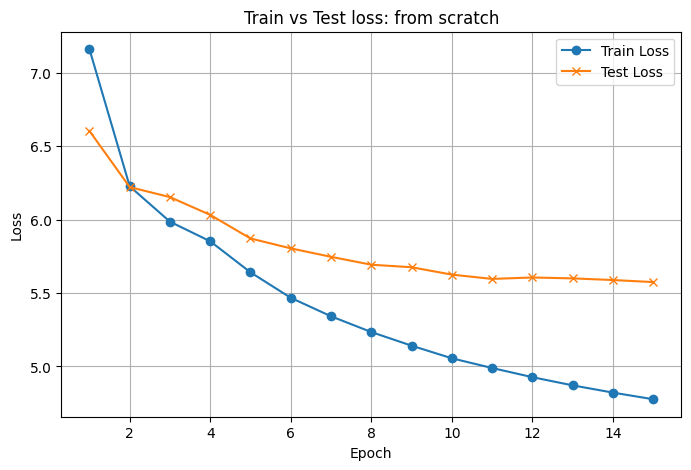

In [37]:
plot_losses(train_losses_from_scratch, test_losses_from_scratch, "Train vs Test loss: from scratch")

In [38]:
# load best model
model_from_scratch.load_state_dict(torch.load("model_from_scratch.pth"))
model_from_scratch.eval()

def generate_from_scratch(
        model,
        tokenizer: GPT2Tokenizer,
        prompt: str,
        max_new_tokens: int = 100,
        temperature: float = 1.0,
        top_k: Optional[int] = None,
        top_p: Optional[float] = None,
        device: str = "cpu"
) -> str:
    """
    Generate text from a trained language model.

    Args:
        model: The trained language model
        tokenizer: GPT2Tokenizer instance
        prompt: The starting text to generate from
        max_new_tokens: Maximum number of tokens to generate
        temperature: Controls randomness (higher = more random)
        top_k: If set, only sample from the top k most probable tokens
        top_p: If set, use nucleus sampling with this probability threshold
        device: Device to run the generation on

    Returns:
        Generated text as a string
    """
    model.eval()
    model.to(device)

    # Encode the prompt
    input_ids = tokenizer.encode(prompt)
    input_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)

    # Get the model's block size (maximum sequence length)
    block_size = None
    if hasattr(model, "posE"):
        block_size = model.posE.num_embeddings
    else:
        # is gpt model
        block_size = model.config.n_positions

    # Generate tokens one by one
    generated_ids = input_ids.copy()

    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Truncate the input if it exceeds the block size
            current_input = input_tensor[:, -block_size:]

            # Get model predictions
            logits = model(current_input)

            # Focus on the last token's predictions
            next_token_logits = logits[:, -1, :]

            # Apply temperature
            next_token_logits = next_token_logits / temperature

            # Apply top-k filtering if specified
            if top_k is not None:
                values, indices = torch.topk(next_token_logits, top_k)
                next_token_logits[next_token_logits < values[:, -1]] = float('-inf')

            # Apply top-p (nucleus) filtering if specified
            if top_p is not None:
                sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
                sorted_indices_to_remove[:, 0] = 0

                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                next_token_logits[indices_to_remove] = float('-inf')

            # Sample from the distribution
            probs = F.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probs, num_samples=1)

            # Add the new token to our sequence
            input_tensor = torch.cat([input_tensor, next_token_id], dim=1)
            generated_ids.append(next_token_id.item())

            # Stop if we generate the end-of-sequence token
            if next_token_id.item() == tokenizer.eos_token_id:
                break

    # Decode the generated tokens
    generated_text = tokenizer.decode(generated_ids)
    return generated_text

for i in range(0, 3):
    generated = generate_from_scratch(
        model=model_from_scratch,
        tokenizer=train_dataset.tokenizer,
        prompt="\n",
        max_new_tokens=250,
        temperature=0.8,
        top_p=0.95,
        device=device
    )
    print(f"Example model from scratch: {i}")
    print(generated)
    print("------------")

Example model from scratch: 0

MUEEN ELIZABETH:
I'll hear me, and being they;
And, madacksanging:
What's name, no brother, and none, this good.

AUIUS:
Your lord, I swear, what wilt the business, I speak, the guest, and I do he is the market ears:
I'll be there to be good wilt now it to prison,
And he a fal.

First Senator:
For it, his son not the want,
I would if he was't
And, no lady to be more.
KING RICHARD II:
And speak.

ClWARD:
KING EDWARD IV:
The Ladyam, as what,
And,--
So, my lord, uncle, and when I must be so thou
I had the goose, I am thenst carry
And by the bank, let him not, and, that done in my body
To break, and show.

MARou show that thou live to come.
DUCH VINCENTIO:
Now:
Till the prince, and my brother to take the hands
I'll bear
------------
Example model from scratch: 1

DUCHESS OF YORK:
I thought, and my lord.

LE:
I saw not-arry, 'tis not deserved you were in the people is his head;
To save a day;
Her winds.

GLOUCESTER:
Well to lay so out.

NORCESTER:

What is he 

# Now, lets finetune gpt2 basic model

GPTShakespeare is a fine-tuned GPT-2 model trained on Shakespearean text. It uses the standard GPT-2 architecture: token and positional embeddings, 12 Transformer blocks with self-attention and MLPs, and a final linear + softmax layer for token prediction. Fine-tuning tailors the model's output to match Shakespeare’s style.

![finetune arq](https://media.githubusercontent.com/media/lgemc/ml-course/refs/heads/master/fine_tuning.png)

In [39]:
class GPTShakespeare(GPT2LMHeadModel):
    def __init__(self,
                 config: GPT2Config,
                 model_name="gpt2",
                 vocab_size=50257,
                 device=None
                 ):
        super().__init__(config)
        self.model = GPT2LMHeadModel.from_pretrained(model_name, config=config)
        self.model.resize_token_embeddings(vocab_size)
        self._device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self._device)

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        **kwargs,
    ) -> Union[Tuple, CausalLMOutputWithCrossAttentions]:
        return self.model(input_ids=input_ids, labels=labels)

# About forward in gpt for fine tune

As forward documentation says, if you sed model(x, labes=x) internally the shift will be performed

**Extracted from original transformers code for gpt model**
```text
Labels for language modeling. Note that the labels *are shifted* inside the model, i.e. you can set
labels = input_ids Indices are selected in [-100, 0, ..., config.vocab_size] All labels set to -100
are ignored (masked), the loss is only computed for labels in [0, ..., config.vocab_size]
```

# About internal loss implementation by default:

Inside gpt model the default loss is
```
loss_type = "ForCausalLM"
```

Which at the end is cross entropy one (as well as is our loss function)

**Extracted from original transformers code for gpt model**
```python
def ForCausalLMLoss(
    logits, labels, vocab_size: int, num_items_in_batch: int = None, ignore_index: int = -100, **kwargs
):
    # Upcast to float if we need to compute the loss to avoid potential precision issues
    logits = logits.float()
    labels = labels.to(logits.device)
    # Shift so that tokens < n predict n
    labels = nn.functional.pad(labels, (0, 1), value=ignore_index)
    shift_labels = labels[..., 1:].contiguous()

    # Flatten the tokens
    logits = logits.view(-1, vocab_size)
    shift_labels = shift_labels.view(-1)
    # Enable model parallelism
    shift_labels = shift_labels.to(logits.device)
    loss = fixed_cross_entropy(logits, shift_labels, num_items_in_batch, ignore_index, **kwargs)
    return loss
```

So we can compare them

In [40]:
from transformers import get_linear_schedule_with_warmup

def train_fine_tunned(
        model: GPT2LMHeadModel,
        train_dataset,
        val_dataset,
        epochs: int,
        batch_size: int,
        learning_rate: float,
        device: str,
        logging_steps: int,
        callback=None,
        model_file_name="model_fine_tunned.pth"
) -> (GPT2LMHeadModel, List, List):
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    model.train()
    num_training_steps = epochs * len(train_dataloader)
    num_warmup_steps = int(0.1 * num_training_steps)  # 10% of steps for warmup

    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )
    test_losses, train_losses = [], []
    best_loss = float('inf')

    for epoch in range(epochs):
        model.train()

        total_train_loss = 0
        print(f"Epoch {epoch + 1}/{epochs}")
        for step, batch in enumerate(train_dataloader):
            x, y = batch
            x, y = x.to(device), y.to(device)
            outputs = model(x, labels=x)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            if step % logging_steps == 0:
                print(f"Step {step}, Loss: {loss.item()}")

            total_train_loss += loss.item()

        train_losses.append(total_train_loss/len(train_dataloader))

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                x, y = batch
                x, y = x.to(device), y.to(device)
                outputs = model(x, labels=x)
                val_loss += outputs.loss.item()


        val_loss /= len(val_dataloader)
        if callback is not None:
            callback(model, val_loss, best_loss, model_file_name)

        if val_loss < best_loss:
            best_loss = val_loss

        test_losses.append(val_loss)
        print(f"Validation Loss: {val_loss}")

    return model, train_losses, test_losses

In [45]:
model_fine_tuned = GPTShakespeare(
    GPT2Config(
        attn_pdrop=.18,
        embd_pdrop=.18,
        resid_pdrop=.18,
        summary_first_dropout=0.18
    ),
    vocab_size=train_dataset.tokenizer.vocab_size,
)

callback_store_always = lambda model, best_loss, curr_loss, _: torch.save(model.state_dict(), model_fine_tuned_path)

print(model_fine_tuned)

model_fine_tuned_path = "model_fine_tunned.pth"
model_fine_tuned, train_losses_fine_tuned, test_losses_fine_tuned = train_fine_tunned(
    model_fine_tuned,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    epochs=15,
    batch_size=32,
    learning_rate=0.00001,
    device=device,
    logging_steps=4,
    callback=callback_store_always
)

GPTShakespeare(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.18, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.18, inplace=False)
          (resid_dropout): Dropout(p=0.18, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.18, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  (model): GPT2LMHeadModel(
    (transformer): GPT2M

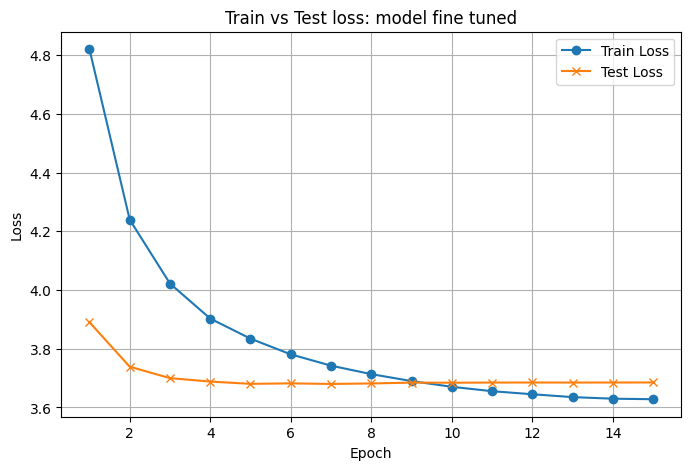

In [46]:
plot_losses(train_losses_fine_tuned, test_losses_fine_tuned, title="Train vs Test loss: model fine tuned")

In [50]:
model_fine_tuned.load_state_dict(torch.load("model_fine_tunned.pth"))
model_fine_tuned.eval()

def generate_fine_tune(
        model,
        tokenizer: GPT2Tokenizer,
        prompt: str,
        max_new_tokens: int = 100,
        temperature: float = 1.0,
        top_k: Optional[int] = None,
        top_p: Optional[float] = None,
        device: str = "cpu"
) -> str:
    """
    Generate text from a trained language model.

    Args:
        model: The trained language model
        tokenizer: GPT2Tokenizer instance
        prompt: The starting text to generate from
        max_new_tokens: Maximum number of tokens to generate
        temperature: Controls randomness (higher = more random)
        top_k: If set, only sample from the top k most probable tokens
        top_p: If set, use nucleus sampling with this probability threshold
        device: Device to run the generation on

    Returns:
        Generated text as a string
    """
    model.eval()
    model.to(device)

    # Encode the prompt
    input_ids = tokenizer.encode(prompt)
    input_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)

    # Get the model's block size (maximum sequence length)
    block_size = model.config.n_positions

    # Generate tokens one by one
    generated_ids = input_ids.copy()

    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Truncate the input if it exceeds the block size
            current_input = input_tensor[:, -block_size:]

            # Get model predictions
            out = model(current_input)

            # Get the logits
            logits = out.logits

            # Focus on the last token's predictions
            next_token_logits = logits[:, -1, :]

            # Apply temperature
            next_token_logits = next_token_logits / temperature

            # Apply top-k filtering if specified
            if top_k is not None:
                values, indices = torch.topk(next_token_logits, top_k)
                next_token_logits[next_token_logits < values[:, -1]] = float('-inf')

            # Apply top-p (nucleus) filtering if specified
            if top_p is not None:
                sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
                sorted_indices_to_remove[:, 0] = 0

                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                next_token_logits[indices_to_remove] = float('-inf')

            # Sample from the distribution
            probs = F.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probs, num_samples=1)

            # Add the new token to our sequence
            input_tensor = torch.cat([input_tensor, next_token_id], dim=1)
            generated_ids.append(next_token_id.item())

            # Stop if we generate the end-of-sequence token
            if next_token_id.item() == tokenizer.eos_token_id:
                break

    # Decode the generated tokens
    generated_text = tokenizer.decode(generated_ids)
    return generated_text

for i in range(0, 3):
    generated = generate_fine_tune(
        model=model_fine_tuned,
        tokenizer=train_dataset.tokenizer,
        prompt="\n",
        max_new_tokens=250,
        temperature=0.8,
        top_p=0.95,
        device=device
    )
    print(f"Example model from finetune {i}")
    print(generated)
    print("------------")

Example model from finetune 0


PAULINA:
Let us see.

FRIAR LAURENCE:
Till we do.

PAULINA:
Now, my lord, as you say, well to see her.

FRIAR LAURENCE:
And she have a good eye, and is well known.

PAULINA:
I'll be at her; but she is well known.

FRIAR LAURENCE:
Well, good fortune, good fortune!

PAULINA:
Then we will get her.

FRIAR LAURENCE:
If she be well-known, good fortune to be known,
Which means we should go and see her.

PAULINA:
What, in my shame, do you know that she lives?

FRIAR LAURENCE:
I do not know her.

PAULINA:
I do not know her; but I must not be so rash as to lie
With any, as my lord.

FRIAR LAURENCE:
My Lord, I would never sleep in falsehood.

PAULINA:
But let her not lie
------------
Example model from finetune 1


First Gentleman:
Madam! how glad my heart is,
To-morrow we will have some health
With that honourable good Marshal Richard of York,
And such a gracious Duke, as thou hast been,
And good Marshal Richard with what royal blood thou hast;
And that with this 

## Conclusion

First, lets compare the validation losses for each model

As shown in the graphs, fine tuned version easily learn how generate text as Shakespeare, in the first 2 or 3 epochs it already reach a good validation set accuracy, under 3.8, and its text is also better from a linguistinc point of view.

## About the overfit and used ways to handle

We handle try to control overfit in two ways:
1. Dataset random index generation: we generate random batches of words to increase the dataset variety and data amount.
2. Drop out: we used drop out at various layers in order to force both models to learn important features dropping some weights in forward passes.
3. Shrink or increase the model size (head dimensions, attention blocks, hidden size dimension)
4. On the fine tunned model we also used a dynamic learning rate based on an scheduler, which allow us to start with small amount for the learning rate and grow little by little based on the quantity of the steps, in order to prevent overfit, catastrophical forgetting and to allow the train process to modify various parameters at the final epochs, when the model is more stable.

We also performed various experiments changing the amount of:
- transformer blocks
- hidden layers dimension
- number of heads
- text sample lengths

And after various iterations, we selected the best based on this two main metrics:

1. Train and test loss
2. Quality of the text generation

Sometimes when we picked small amount of heads (2 or 3) and low hidden dimensions, we
got stuck in low values for both losses (train and tests) and very bad texts, so we decided to chose 128 for model dimension, 8 heads and 4 blocks because was the most performing model over all metrics.


# About the model size and compute requirements, an overview

As a conclusion, we also noticed that fine tuned model requires 4x more computing
resources than the one from scratch, also it takes 10x more time for train.

Also pretrained model requires 20x more vram memory at eval time than the one trained from scratch

In a limited setting like an embed system or when the available resources for train are less than fine tune requires, maybe the model from zero can be used.

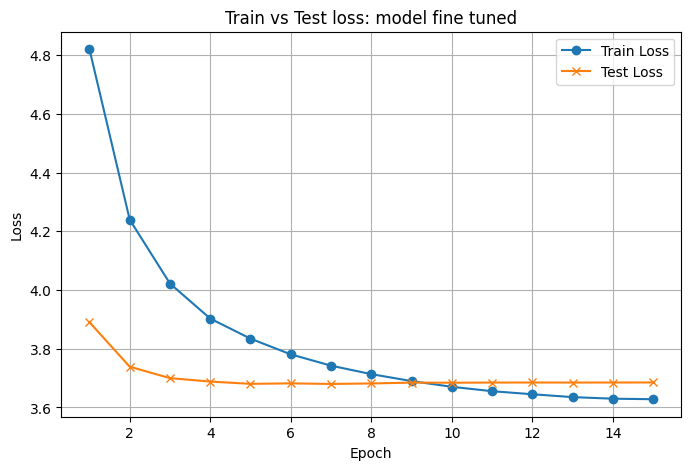

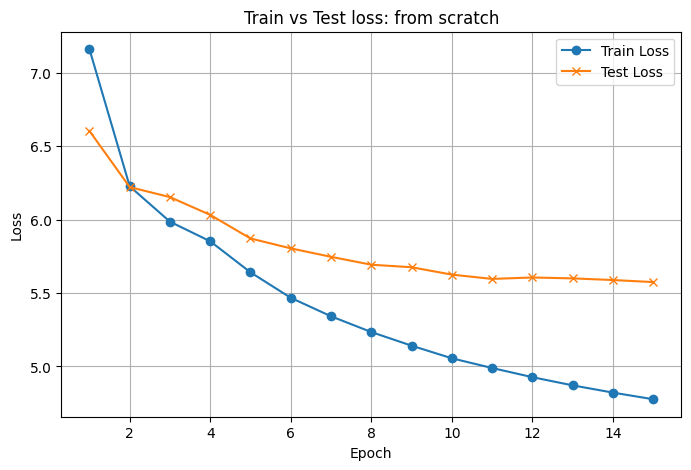

In [51]:
plot_losses(train_losses_fine_tuned, test_losses_fine_tuned, title="Train vs Test loss: model fine tuned")
plot_losses(train_losses_from_scratch, test_losses_from_scratch, "Train vs Test loss: from scratch")